# Classificador de Figuinhas

Classificador de aves, de tipos da ave comumente conhecida como Figuinha (gênero Conirostrum). Optou-se por classificar as aves:
- Figuinha-amazônica (Conirostrum margaritae);
- Figuinha-do-mangue (Conirostrum bicolor);
- Figuinha-de-rabo-castanho (Conirostrum speciosum).



In [2]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [3]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [4]:
key = os.environ.get('AZURE_SEARCH_KEY', 'adicione sua key aqui')

Os nomes científicos foram utilizados para maior eficiência na busca.

In [5]:
tipos_figuinhas = 'margaritae','speciosum','bicolor'
path = Path('figuinhas')

In [6]:
if not path.exists():
    path.mkdir()
    for o in tipos_figuinhas:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'Conirostrum {o}')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [31]:
verify_images(get_image_files(path)).map(Path.unlink);

In [144]:
figuinhas = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(256))

In [145]:
dls = figuinhas.dataloaders(path)

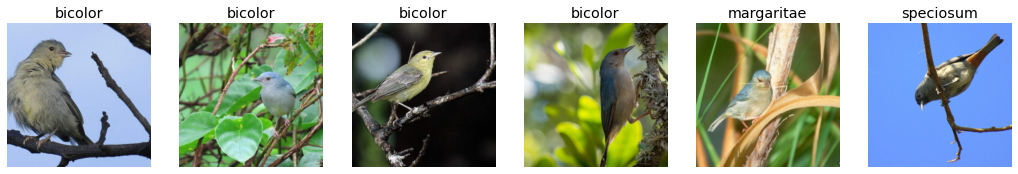

In [146]:
dls.valid.show_batch(max_n=6, nrows=1)

## Treinamento do modelo

In [152]:
figuinhas = figuinhas.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = figuinhas.dataloaders(path)

In [158]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.732139,1.495254,0.555556,00:04


epoch,train_loss,valid_loss,error_rate,time
0,1.198257,1.186134,0.492063,00:05
1,1.195830,0.922187,0.396825,00:05
2,1.047938,0.824334,0.317460,00:05
3,0.904393,0.780119,0.317460,00:05


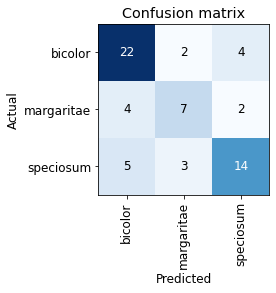

In [159]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

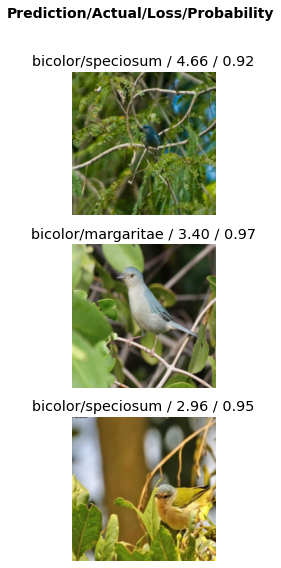

In [160]:
interp.plot_top_losses(3, nrows=3)

In [161]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [157]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [162]:
learn.export('figuinhas.pkl')

## Utilização do modelo para predição

In [163]:
path = Path()
learn_inf = load_learner(path/'figuinhas.pkl')
btn_upload = widgets.FileUpload()
out_pl = widgets.Output()
lbl_pred = widgets.Label()

In [164]:
def on_click(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Predição: {pred}; Probabilidade: {probs[pred_idx]:.04f}'


In [165]:
btn_upload.observe(on_click, names=['data'])

In [166]:
#hide_output
display(VBox([widgets.Label('Selecione uma figuinha!'), 
      btn_upload, out_pl, lbl_pred]))